## `SciPy()`  variations

`1610.04.May.20`

Having not made progress on `SNOPT`, I am moving forward using `scipy.minimize()`. In this notebook I will accomplish 4 things:

- cs3 optimization. with `scipy()` and BNM (**Completed `1526.05.May.20`**)

- cs4 opt. with `scipy()` and BNM

- cs4 opt. with `scipy()` and BPM


"BNM" is Dr. Ning's "Boundary Normal Method". "BPM" is my "Boundary Partition Method" that kind of exhaustively partitions the space into portions and uses the `getUpDwnYvals()` function.

`1730.06.May.20` Ok I've been having some serious issues. The potimization isn't ... optimizing. It's perturbing the turbine coordinates by *very* small amounts and calling it "optimized." An overlay of starting and ending locations look exactly the same. It might be the scaling? Perhaps the optimzer thinks it can't get any better. I'll have to look if there's a scaling option.

Other options for the difficulty:

- The optimizer isn't syntactically configured correctly

- The constraint functions have a bug that gives bad information on return

- There's something off with the scaling:
   - AEP is on order of 1e6
   - Turb Locations is like 1e3
   - Spacing/boundary constraints are from order 1e3 to 1e-2. Lots of variability there depending how far away things are.
   
`1730.06.May.20` It looks like, for now, it's running and working. I had to change the spacing constraint function because it was not only counting the wrong pairs (`for-loop` indexing was wrong) but it was returning neagative instead of positive values, and the optimizer only works in the positive. Regardless, it's running now.

### Follow-On ToDo

`1200.05.May.20`

- Get SNOPT working

- Mapping Method

## cs3 BNM with `SciPy()`

`1202.05.May.20` **Completed `1526.05.May.20`**

To get the BNM working with `SciPy()` I'll need to:

- Load the proper boundary

- Implement the normals into the code (I think already done?)

- Run a single opt to test

## Housekeeping

`1303.05.May.20` **Completed `1526.05.May.20`**

In trying to transfer files to the workstation I realized everything is abit double-done and some things are defunct. I need to cleanup my file keeping and get more organized.

- Startup files only in original folder (read from there) (**Completed `1505.05.May.20`**) 

- Different header/helping files for all functions (no more sandboxes)  (**Completed `1505.05.May.20`**)

# Boundary Problem

`2342.06.May.20`

Though the optimization completed, an unexpected error occurred in the boundary calculation. I previously fixed a bug in the spacing constraint, but it appears there is a bug in the boundary constraint I didn't know about. The optimization terminated with six turbines above the upper boundary. I need to debug and resolve.

I will here test the `checkBoundaryConstraints()` function:

## cs4 Boundary Turbines

In [4]:
#--- Load boundary, turb attributes, and windrose data ---#
%run "../baker_cs34_functions.py"

#-- Load the Boundary --#
fn = "../../startup-files/iea37-boundary-cs3.yaml"
bndryPts = getTurbAtrbtCs3YAML(fn)      # Pull the boundary vertices
clsdBP = closeBndryList(bndryPts)       # repeat the first so it's 'closed'
#- Load the turbine and windrose atributes -#
fname_turb = "../../startup-files/iea37-10mw.yaml"
fname_wr = "../../startup-files/iea37-windrose-cs3.yaml"
wind_dir, wind_dir_freq, wind_speeds, wind_speed_probs, num_speed_bins, min_speed, max_speed = iea37aepC.getWindRoseYAML(fname_wr)
turb_ci, turb_co, rated_ws, rated_pwr, turb_diam = iea37aepC.getTurbAtrbtYAML(fname_turb)
fAEPscale = 1.0
fTCscale = 1.0
fMinDist = 2*turb_diam
numGridLines = 20

#-- Make boundary splines and random turbine locations--#
#-- Spline the boundary --#
vertexList = [0, 6, 8, 9, 18]       # Hard code the vertices (though this could be done algorithmically)
numSides = len(vertexList) - 1      # The number of sides for our original coordinate system. Usually (4) to Euclidean, but could be any number)
splineList = np.empty(numSides, interp1d)                  # Init. array IOT save the Splines for each "side"
buf = np.zeros((numSides, numGridLines, 2))                # Used to initalize the recarray to zeros
segCoordList = np.recarray([numSides, numGridLines], dtype=coordinate, buf=buf)

#- Create the splines for each side (<numSides> many)-#
for i in range(numSides):
    BndPts = clsdBP[vertexList[i]:(vertexList[i+1]+1)]      # Extract the points for the "edge" we want
    segCoordList[i] = sliceBoundary(BndPts, numGridLines)    # Reparameterize the boundry to be defined by <numGridLines> many points
    splineList[i] = interp1d(segCoordList[i].x, segCoordList[i].y, kind='linear')   # Make the spline using NumPy's <interp1d>

In [279]:
Args = dict([('wind_dir_freq', wind_dir_freq), \
                ('wind_speeds', wind_speeds), \
                ('wind_speed_probs', wind_speed_probs), \
                ('wind_dir', wind_dir), \
                ('turb_diam', turb_diam), \
                ('turb_ci', turb_ci), \
                ('turb_co', turb_co), \
                ('rated_ws', rated_ws), \
                ('rated_pwr', rated_pwr), \
                ('fAEPscale', fAEPscale), \
                ('fTCscale', fTCscale),
                ('fMinTurbDist', fMinDist)])

In [53]:
#-- Testing --#
numTurbs = 25
vertexPts = bndryPts[vertexList[0:4]]  # Make an array of just the four "vertex" points we're using
turbRandoList = iea37cs3randomstarts(numTurbs, splineList, vertexPts, fMinDist)

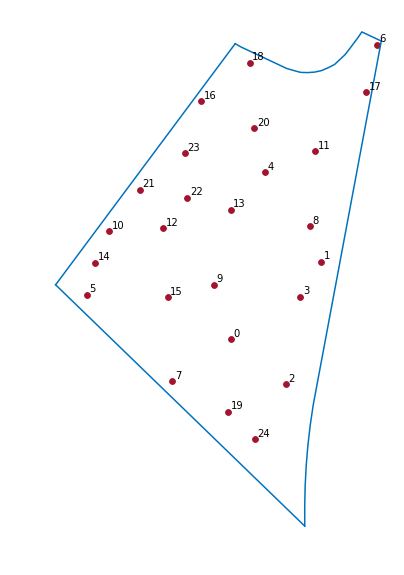

In [60]:
#-- Print the random turbine locations (with numbers) --#
#-- Plot the boundary --#
plt.figure(figsize=(20,10))
for i in range(numSides):
    plt.hold = True
    printBoundaryArray(segCoordList[i].x, splineList[i](segCoordList[i].x), 5)

#-- Plot the turbine locations --#
printTurbines(turbRandoList, getPltClrs().getColor(1), turb_diam/6, True)
#-- End print of turbine locations--#

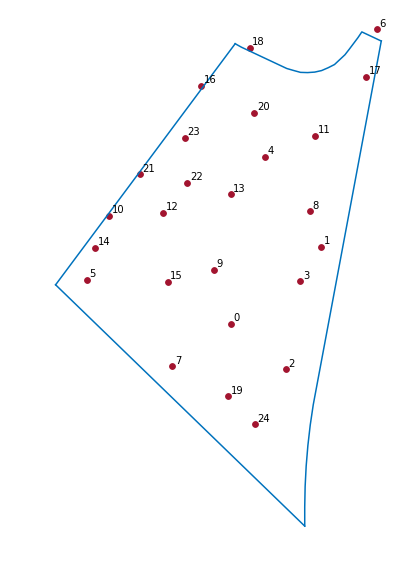

In [67]:
#print(turbRandoList)
#--- Shift everything up to check
#-- Initialize our array --#
buf = np.zeros((numTurbs, 2))
turbRandoListAug = np.recarray((numTurbs), dtype=coordinate, buf=buf)
    
for i in range(numTurbs):
    turbRandoListAug[i].y = turbRandoList[i].y + 200
    turbRandoListAug[i].x = turbRandoList[i].x

x0 = makeCoordArray(turbRandoListAug) # Make it an array for the checkBndryCons() function

#-- Print the random turbine locations (with numbers) --#
#-- Plot the boundary --#
plt.figure(figsize=(20,10))
for i in range(numSides):
    plt.hold = True
    printBoundaryArray(segCoordList[i].x, splineList[i](segCoordList[i].x), 5)

#-- Plot the turbine locations --#
printTurbines(turbRandoListAug, getPltClrs().getColor(1), turb_diam/6, True)
#-- End print of turbine locations--#


In [82]:
def checkBndryConsTest(x0, splineList, coordsCorners):
    x0s = makeArrayCoord(x0)
    numTurbs = int(len(x0s))
    numSides = int(len(coordsCorners)-1)

    # Check to make sure our poits are in
    bndryCons = np.zeros((numTurbs, numSides))   # four values (two x and two y) for every turbine
    bCons = np.ones((numTurbs,numSides))
    
    xmin = coordsCorners[2].x   # Our minimum x-value
    xmax = coordsCorners[0].x   # our maximum x-value
    
    # For every turbine
    for i in range(numTurbs):
        #- Check x-vals
        bndryCons[i,0] = (xmax - x0s[i].x)   # Positive good, neg bad
        bndryCons[i,1] = (x0s[i].x - xmin) # pos good, neg bad
        
        #- Check y-vals
        ymin,ymax = getUpDwnYvals(x0s[i].x, splineList, coordsCorners)
        bndryCons[i,2] = (ymax - x0s[i].y)
        bndryCons[i,3] = (x0s[i].y - ymin)
        
        #- Fill in our boolean array (False = out, True = in bounds)
        for j in range(numSides):
            if (bndryCons[i,j] < 0):
                bCons[i,j] = False
    
    return bndryCons.flatten(), bCons

coordsCorners = clsdBP[vertexList]
[fBoundaryCons, bCons] = checkBndryConsTest(x0, splineList, coordsCorners) 
print(fBoundaryCons)
print(fBoundaryCons.flatten())

#- Find which ones are out
for cntr in range(numTurbs):
    if(np.all(bCons[cntr]) == False):
        print(cntr)

[1972.60280874 2292.89719126 3590.54095984 1708.72268999  790.57829079
 3474.92170921 2302.83054141 1535.98280855 1246.22437052 3019.27562948
 3941.7734339  1819.71709109 1057.9758548  3207.5241452  2737.43881235
 3151.7293048  1527.01566511 2738.48433489 1292.69560426 4328.77660336
 3853.24522577  412.25477423  484.60224164  468.18838076   58.43369522
 4207.06630478 -124.88381855  464.83162527 2736.81881091 1528.68118909
 3118.85360399  414.18759441  937.38576659 3328.11423341 1816.41729459
 2863.03076004 2194.3847334  2071.1152666  2583.42366886 2203.27012539
 3564.95090203  700.54909797   38.89003736 1580.19760649  869.51153528
 3395.98846472  836.28252811 3407.08894199 2859.52769569 1405.97230431
  943.98769191 2305.45248595 1973.77061518 2291.72938482 1892.49275991
 3404.07192163 3748.05181917  517.44818083  208.04029791  987.87010772
 2797.63052984 1467.86947016 1934.0179081  1458.47710591 2358.12152144
 1907.37847856  -43.69973067 4451.97431009  193.8809493  4071.6190507
  560.5

# cs4 in `SciPy()`

`1227.06.May.20`

The code should run the same. I'll have to pre-apportion turbines, and then run the same optimization code for the different boundary verticies. I'll just have to visually check pice by pice that the boundaries and random turbine locations are "correct." (in-bounds and sparated correctly).

## Individual Sections

In [266]:
#-- Load all section vertices --#
# Run the code previously written
%run "../baker_cs34_functions.py"
numGridLines = 25                   # How many gridlines we'll use for the visualization

#- Rip the boundary coordinates from the .yaml file -#
fn = "../../startup-files/iea37-boundary-cs4.yaml"
[coordList3a, coordList3b, coordList4a, coordList4b, coordList4c] = getTurbAtrbtCs4YAML(fn)
#print(coordList3a)
#print(coordList3b)
clsdBP3a = closeBndryList(coordList3a)    # Duplicate the first coordinate for a closed boundary
coordList3b = np.roll(coordList3b, 1)     # Shift our points to the right so rightmost vertex is zero
clsdBP3b = closeBndryList(coordList3b)    # Duplicate the first coordinate for a closed boundary
coordList4a = np.roll(coordList4a, -3)    # Shift our points to the left so rightmost vertex is zero
clsdBP4a = closeBndryList(coordList4a)    # Duplicate the first coordinate for a closed boundary
clsdBP4b = closeBndryList(coordList4b)    # Duplicate the first coordinate for a closed boundary
clsdBP4c = closeBndryList(coordList4c)    # Duplicate the first coordinate for a closed boundary

numTurbsCs3 = 25
numTurbs3a = 31
numTurbs3b = 11
numTurbs4a = 14
numTurbs4b = 16
numTurbs4c = 9

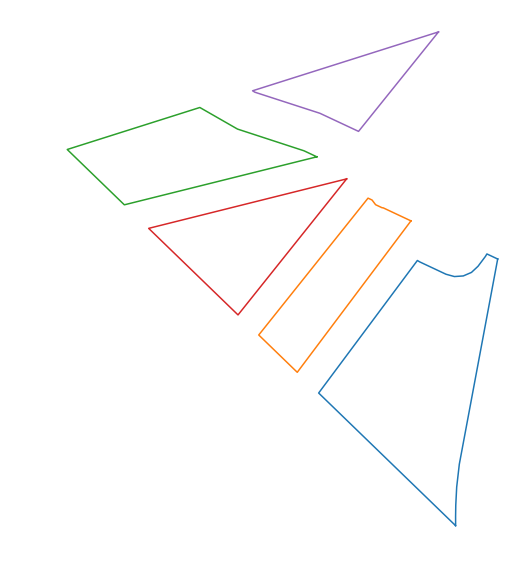

In [157]:
#-- Print the full farm --#
plt.figure(figsize=(20,10))
printBoundary(clsdBP3a)
printBoundary(clsdBP3b)
printBoundary(clsdBP4a)
printBoundary(clsdBP4b)
printBoundary(clsdBP4c)

### Section IIIa

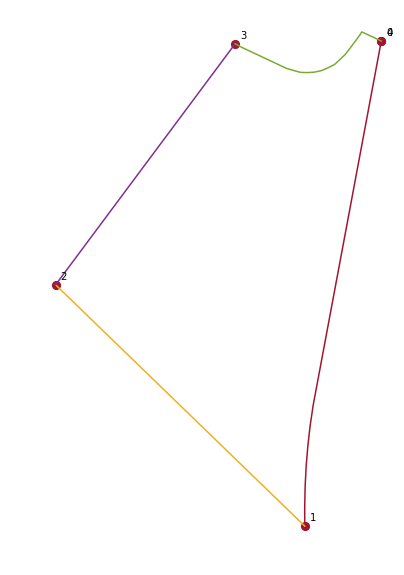

In [254]:
#--- Make the boundary ---#
plt.figure(figsize=(20,10))
vertexList3a = [0, 6, 8, 9, 18]       # Hard code the vertices (though this could be done algorithmically)
vertexPts3a = clsdBP3a[vertexList3a] 
numSides3a = len(vertexList3a) - 1      # The number of sides for our original coordinate system. Usually (4) to Euclidean, but could be any number)
printTurbines(vertexPts3a, getPltClrs().getColor(1), turb_diam/3, True)

#-- Plot our space (with splines) --#
splineList3a = np.empty(numSides3a, interp1d)                  # Init. array IOT save the Splines for each "side"
segCoordList3a = np.recarray([numSides3a, numGridLines], coordinate)

#- Create the splines for each side (<numSides> many)-#
for i in range(numSides3a):
    BndPts3a = clsdBP3a[vertexList3a[i]:(vertexList3a[i+1]+1)]      # Extract the points for the "edge" we want
    segCoordList3a[i] = sliceBoundary(BndPts3a, numGridLines)    # Reparameterize the boundry to be defined by <numGridLines> many points
    splineList3a[i] = interp1d(segCoordList3a[i].x, segCoordList3a[i].y, kind='linear')   # Make the spline using NumPy's <interp1d>
    
# Plot the boundary and the endpoints.
for i in range(numSides3a):
    plt.hold = True
    printBoundaryArray(segCoordList3a[i].x, splineList3a[i](segCoordList3a[i].x), i+1)

### Section IIIb
`1802.06.May.20`

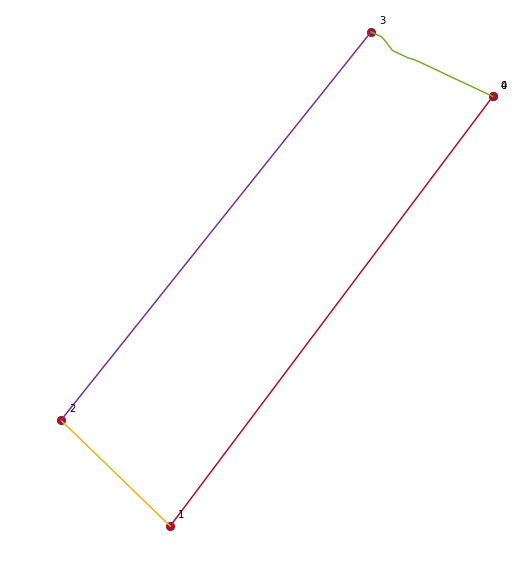

In [121]:
#--- Make the boundary ---#
plt.figure(figsize=(20,10))
vertexList3b = [0, 1, 2, 3, 8]       # Hard code the vertices (though this could be done algorithmically)
vertexPts3b = clsdBP3b[vertexList3b] 
numSides3b = len(vertexList3b) - 1      # The number of sides for our original coordinate system. Usually (4) to Euclidean, but could be any number)
printTurbines(vertexPts3b, getPltClrs().getColor(1), turb_diam/3, True)

#-- Plot our space (with splines) --#
splineList3b = np.empty(numSides3b, interp1d)                  # Init. array IOT save the Splines for each "side"
segCoordList3b = np.recarray([numSides3b, numGridLines], coordinate)

#- Create the splines for each side (<numSides> many)-#
for i in range(numSides3b):
    BndPts3b = clsdBP3b[vertexList3b[i]:(vertexList3b[i+1]+1)]      # Extract the points for the "edge" we want
    segCoordList3b[i] = sliceBoundary(BndPts3b, numGridLines)    # Reparameterize the boundry to be defined by <numGridLines> many points
    splineList3b[i] = interp1d(segCoordList3b[i].x, segCoordList3b[i].y, kind='linear')   # Make the spline using NumPy's <interp1d>
    
# Plot the boundary and the endpoints.
for i in range(numSides3b):
    plt.hold = True
    printBoundaryArray(segCoordList3b[i].x, splineList3b[i](segCoordList3b[i].x), i+1)

In [124]:
turbRandoList3b = iea37cs3randomstarts(numTurbs3b, splineList3b, vertexPts3b, fMinDist)

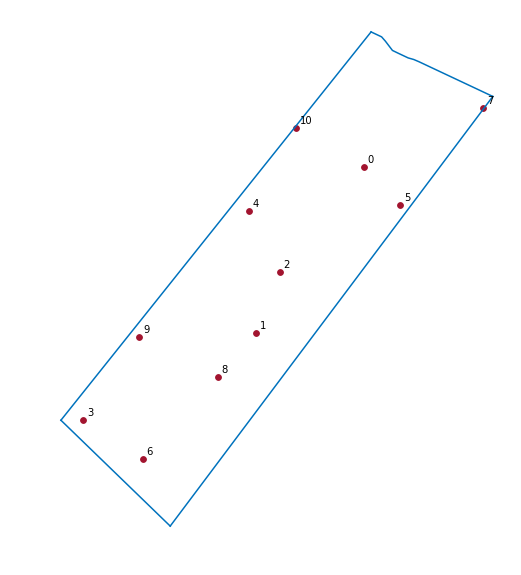

In [125]:
#-- Print the random turbine locations (with numbers) --#
#-- Plot the boundary --#
plt.figure(figsize=(20,10))
for i in range(numSides3b):
    plt.hold = True
    printBoundaryArray(segCoordList3b[i].x, splineList3b[i](segCoordList3b[i].x), 5)

#-- Plot the turbine locations --#
printTurbines(turbRandoList3b, getPltClrs().getColor(1), turb_diam/6, True)
#-- End print of turbine locations--#

### Section IVa

`0101.07.May.20`

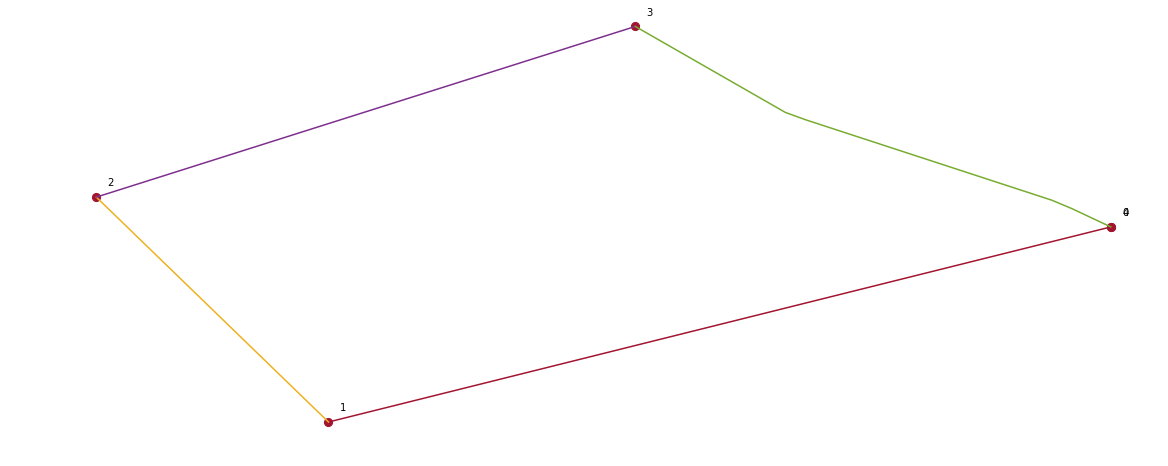

In [242]:
#--- Make the boundary ---#
plt.figure(figsize=(20,10))
vertexList4a = [0, 1, 2, 3, 6]       # Hard code the vertices (though this could be done algorithmically)
vertexPts4a = clsdBP4a[vertexList4a] 
numSides4a = len(vertexList4a) - 1      # The number of sides for our original coordinate system. Usually (4) to Euclidean, but could be any number)
printTurbines(vertexPts4a, getPltClrs().getColor(1), turb_diam/3, True)

#-- Plot our space (with splines) --#
splineList4a = np.empty(numSides4a, interp1d)                  # Init. array IOT save the Splines for each "side"
segCoordList4a = np.recarray([numSides4a, numGridLines], coordinate)

#- Create the splines for each side (<numSides> many)-#
for i in range(numSides4a):
    BndPts4a = clsdBP4a[vertexList4a[i]:(vertexList4a[i+1]+1)]      # Extract the points for the "edge" we want
    segCoordList4a[i] = sliceBoundary(BndPts4a, numGridLines)    # Reparameterize the boundry to be defined by <numGridLines> many points
    splineList4a[i] = interp1d(segCoordList4a[i].x, segCoordList4a[i].y, kind='linear')   # Make the spline using NumPy's <interp1d>
    
# Plot the boundary and the endpoints.
for i in range(numSides4a):
    plt.hold = True
    printBoundaryArray(segCoordList4a[i].x, splineList4a[i](segCoordList4a[i].x), i+1)

In [153]:
turbRandoList4a = iea37cs3randomstarts(numTurbs4a, splineList4a, vertexPts4a, fMinDist)

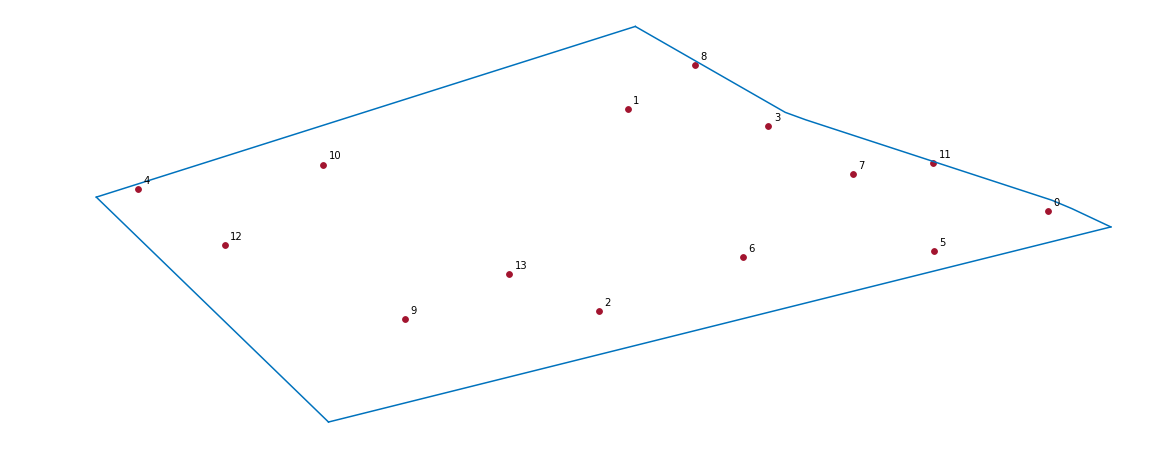

In [163]:
#-- Print the random turbine locations (with numbers) --#
#-- Plot the boundary --#
plt.figure(figsize=(20,10))
for i in range(numSides4a):
    plt.hold = True
    printBoundaryArray(segCoordList4a[i].x, splineList4a[i](segCoordList4a[i].x), 5)

#-- Plot the turbine locations --#
printTurbines(turbRandoList4a, getPltClrs().getColor(1), turb_diam/6, True)
#-- End print of turbine locations--#

### Section IVb

`0111.07.May.20`

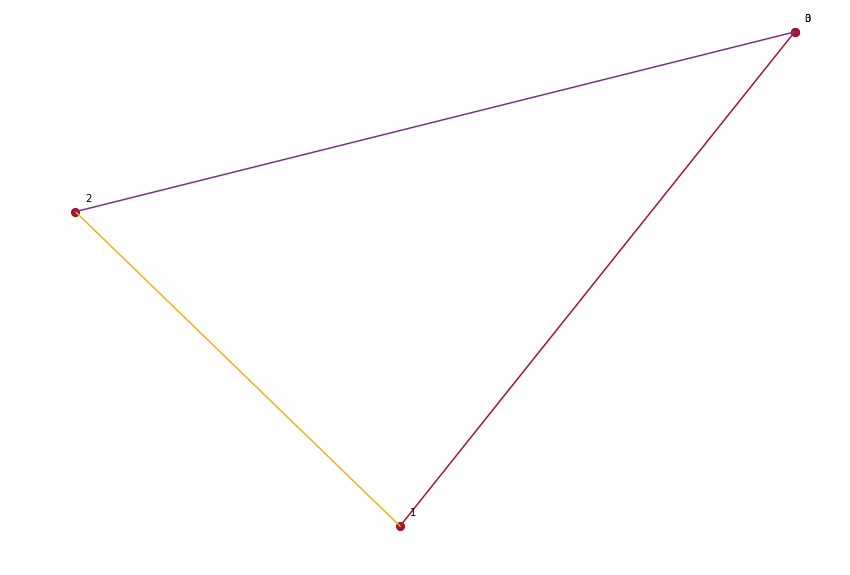

In [159]:
#--- Make the boundary ---#
plt.figure(figsize=(20,10))
vertexList4b = [0, 1, 2, 3]       # Hard code the vertices (though this could be done algorithmically)
vertexPts4b = clsdBP4b[vertexList4b] 
numSides4b = len(vertexList4b) - 1      # The number of sides for our original coordinate system. Usually (4) to Euclidean, but could be any number)
printTurbines(vertexPts4b, getPltClrs().getColor(1), turb_diam/3, True)

#-- Plot our space (with splines) --#
splineList4b = np.empty(numSides4b, interp1d)                  # Init. array IOT save the Splines for each "side"
segCoordList4b = np.recarray([numSides4b, numGridLines], coordinate)

#- Create the splines for each side (<numSides> many)-#
for i in range(numSides4b):
    BndPts4b = clsdBP4b[vertexList4b[i]:(vertexList4b[i+1]+1)]      # Extract the points for the "edge" we want
    segCoordList4b[i] = sliceBoundary(BndPts4b, numGridLines)    # Reparameterize the boundry to be defined by <numGridLines> many points
    splineList4b[i] = interp1d(segCoordList4b[i].x, segCoordList4b[i].y, kind='linear')   # Make the spline using NumPy's <interp1d>
    
# Plot the boundary and the endpoints.
for i in range(numSides4b):
    plt.hold = True
    printBoundaryArray(segCoordList4b[i].x, splineList4b[i](segCoordList4b[i].x), i+1)

There is a problem here. `getUpDownYVals()` only works on 4-sides areas. I'll have to reqwrite it to work on triangles.

`0130.07.May.20` Though a twist of fate, the way I wrote it, it'll actually work normally for these areas as well. This is only because the shape is an inverted triangle. But since it ain't broke, I won't alter it.

In [192]:
turbRandoList4b = iea37cs3randomstarts(numTurbs4b, splineList4b, vertexPts4b, fMinDist)

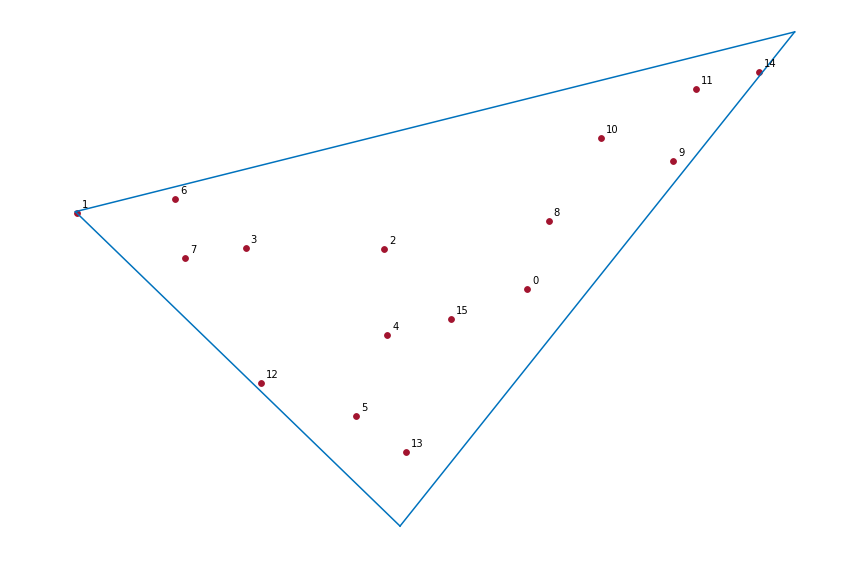

In [193]:
#-- Print the random turbine locations (with numbers) --#
#-- Plot the boundary --#
plt.figure(figsize=(20,10))
for i in range(numSides4b):
    plt.hold = True
    printBoundaryArray(segCoordList4b[i].x, splineList4b[i](segCoordList4b[i].x), 5)

#-- Plot the turbine locations --#
printTurbines(turbRandoList4b, getPltClrs().getColor(1), turb_diam/6, True)
#-- End print of turbine locations--#

### Section IVc

`0132.07.May.20`

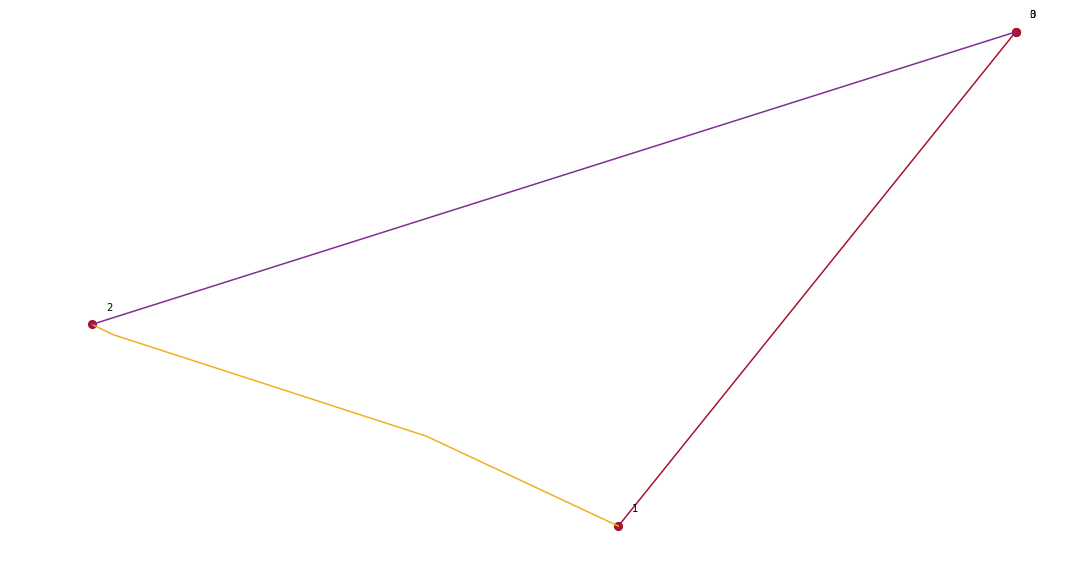

In [201]:
#--- Make the boundary ---#
plt.figure(figsize=(20,10))
vertexList4c = [0, 1, 4, 5]       # Hard code the vertices (though this could be done algorithmically)
vertexPts4c = clsdBP4c[vertexList4c] 
numSides4c = len(vertexList4c) - 1      # The number of sides for our original coordinate system. Usually (4) to Euclidean, but could be any number)
printTurbines(vertexPts4c, getPltClrs().getColor(1), turb_diam/3, True)

#-- Plot our space (with splines) --#
splineList4c = np.empty(numSides4c, interp1d)                  # Init. array IOT save the Splines for each "side"
segCoordList4c = np.recarray([numSides4c, numGridLines], coordinate)

#- Create the splines for each side (<numSides> many)-#
for i in range(numSides4c):
    BndPts4c = clsdBP4c[vertexList4c[i]:(vertexList4c[i+1]+1)]      # Extract the points for the "edge" we want
    segCoordList4c[i] = sliceBoundary(BndPts4c, numGridLines)    # Reparameterize the boundry to be defined by <numGridLines> many points
    splineList4c[i] = interp1d(segCoordList4c[i].x, segCoordList4c[i].y, kind='linear')   # Make the spline using NumPy's <interp1d>
    
# Plot the boundary and the endpoints.
for i in range(numSides4c):
    plt.hold = True
    printBoundaryArray(segCoordList4c[i].x, splineList4c[i](segCoordList4c[i].x), i+1)

In [211]:
turbRandoList4c = iea37cs3randomstarts(numTurbs4c, splineList4c, vertexPts4c, fMinDist)

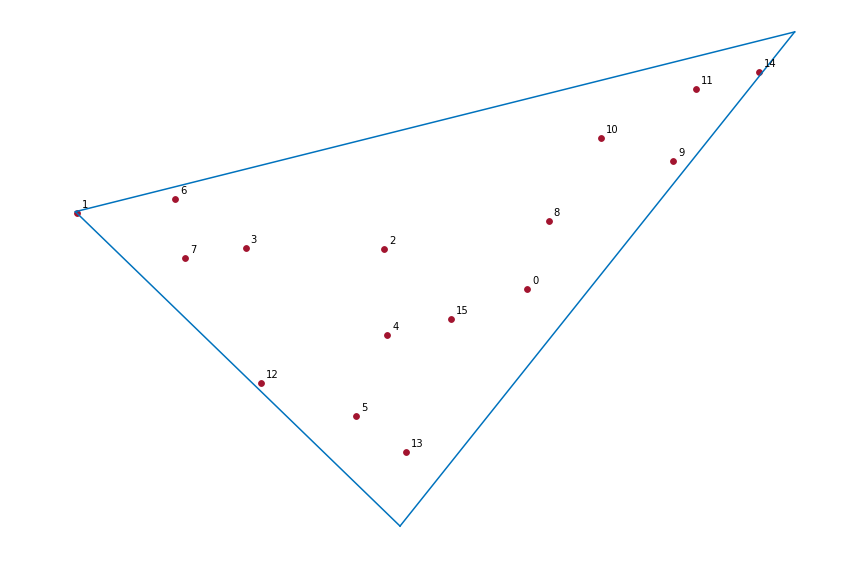

In [212]:
#-- Print the random turbine locations (with numbers) --#
#-- Plot the boundary --#
plt.figure(figsize=(20,10))
for i in range(numSides4b):
    plt.hold = True
    printBoundaryArray(segCoordList4b[i].x, splineList4b[i](segCoordList4b[i].x), 5)

#-- Plot the turbine locations --#
printTurbines(turbRandoList4b, getPltClrs().getColor(1), turb_diam/6, True)
#-- End print of turbine locations--#

## cs4 Boundary Random Starts

`0205.20.May.20`

Now that I've got all areas working with the boundary conditions, I'll generate 200 random turbine locations for each area, and do the optomizations for each.

In [222]:
numRestarts = 200

In [264]:
#--- Make random starts for cs3 (25 turbs in 3a) ---#
RandoTurbListCs3 = np.zeros((numRestarts, numTurbsCs3*2))

for i in range(numRestarts):
    RandoTurbListCs3[i] = makeCoordArray(iea37cs3randomstarts(numTurbsCs3, splineList3a, vertexPts3a, fMinDist))
    
np.savetxt('../results/randostarts-Cs3-' + str(numRestarts) + '.csv', RandoTurbListCs3, delimiter=',')

In [268]:
#--- Make random starts for 3a ---#
RandoTurbList3a = np.zeros((numRestarts, numTurbs3a*2))

for i in range(numRestarts):
    RandoTurbList3a[i] = makeCoordArray(iea37cs3randomstarts(numTurbs3a, splineList3a, vertexPts3a, fMinDist))
    
np.savetxt('../results/randostarts-3a-' + str(numRestarts) + '.csv', RandoTurbList3a, delimiter=',')

In [223]:
#--- Make random starts for 3b ---#
RandoTurbList3b = np.zeros((numRestarts, numTurbs3b*2))

for i in range(numRestarts):
    RandoTurbList3b[i] = makeCoordArray(iea37cs3randomstarts(numTurbs3b, splineList3b, vertexPts3b, fMinDist))
    
np.savetxt('../results/randostarts-3b-' + str(numRestarts) + '.csv', RandoTurbList3b, delimiter=',')

In [224]:
#--- Make random starts for 4a ---#
RandoTurbList4a = np.zeros((numRestarts, numTurbs4a*2))

for i in range(numRestarts):
    RandoTurbList4a[i] = makeCoordArray(iea37cs3randomstarts(numTurbs4a, splineList4a, vertexPts4a, fMinDist))
    
np.savetxt('../results/randostarts-4a-' + str(numRestarts) + '.csv', RandoTurbList4a, delimiter=',')

In [225]:
#--- Make random starts for 4b ---#
RandoTurbList4b = np.zeros((numRestarts, numTurbs4b*2))

for i in range(numRestarts):
    RandoTurbList4b[i] = makeCoordArray(iea37cs3randomstarts(numTurbs4b, splineList4b, vertexPts4b, fMinDist))
    
np.savetxt('../results/randostarts-4b-' + str(numRestarts) + '.csv', RandoTurbList4b, delimiter=',')

In [227]:
#--- Make random starts for 4c ---#
RandoTurbList4c = np.zeros((numRestarts, numTurbs4c*2))

for i in range(numRestarts):
    RandoTurbList4c[i] = makeCoordArray(iea37cs3randomstarts(numTurbs4c, splineList4c, vertexPts4c, fMinDist))
    
np.savetxt('../results/randostarts-4c-' + str(numRestarts) + '.csv', RandoTurbList4c, delimiter=',')

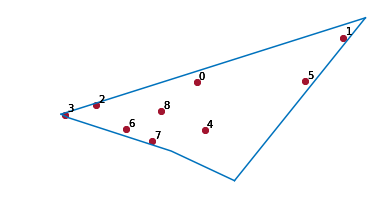

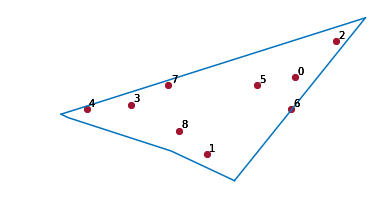

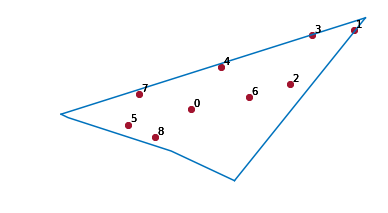

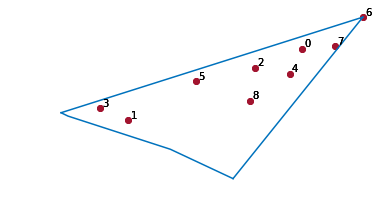

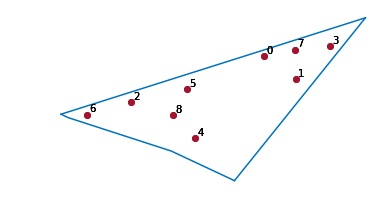

In [234]:
#--- Print some of the starts to verify visually ---#
for j in range(5):
    plt.figure(j)
    for i in range(numSides4c):
        
        plt.hold = True
        printBoundaryArray(segCoordList4c[i].x, splineList4c[i](segCoordList4c[i].x), 5)

        #-- Plot the turbine locations --#
        printTurbines(makeArrayCoord(RandoTurbList4c[j]), getPltClrs().getColor(1), turb_diam/6, True)

## Optimizations

Just for time, I need to run them in parallel.

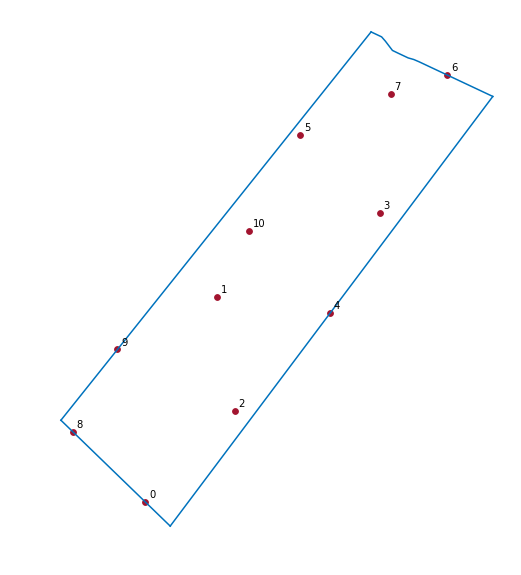

In [250]:
tempTurbs3b = np.loadtxt('../results/turblocs-bpm-1run3b-(0).csv', delimiter=',')
x0s = makeArrayCoord(tempTurbs3b)
print(iea37sb.)
#-- Print the random turbine locations (with numbers) --#
#-- Plot the boundary --#
plt.figure(figsize=(20,10))
for i in range(numSides3b):
    plt.hold = True
    printBoundaryArray(segCoordList3b[i].x, splineList3b[i](segCoordList3b[i].x), 5)

#-- Plot the turbine locations --#
printTurbines(x0s, getPltClrs().getColor(1), turb_diam/6, True)
#-- End print of turbine locations--#

## Analyze Results

`1146.07.May.20`

I optimized each seciton in parallele. I now need to collate the results, reading in all the separately optimized turbine locations then put them together in one file, and one visualization.

2902057.989605717


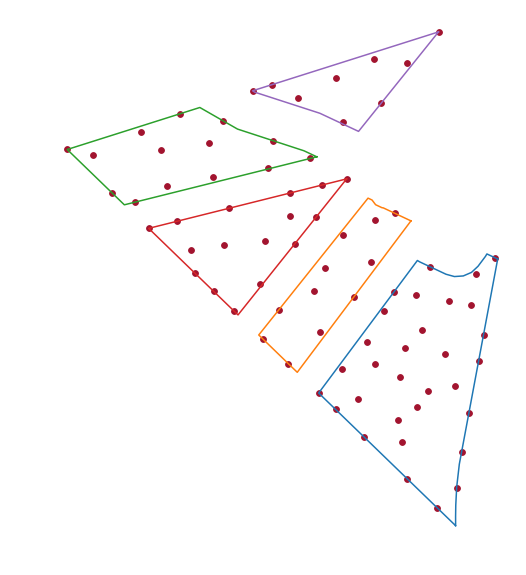

In [383]:
#-- Read and print optimized locations --#

#- Read all the turbine locations -#
tempTurbs3a = np.loadtxt('../results/turblocs-bpm-1run-3a-(0).csv', delimiter=',')
tempTurbs3b = np.loadtxt('../results/turblocs-bpm-1run3b-(0).csv', delimiter=',')
tempTurbs4a = np.loadtxt('../results/turblocs-bpm-1run4a-(0).csv', delimiter=',')
tempTurbs4b = np.loadtxt('../results/turblocs-bpm-1run4b-(0).csv', delimiter=',')
tempTurbs4c = np.loadtxt('../results/turblocs-bpm-1run4c-(5).csv', delimiter=',')

#- Convert them to <coordinate> -#
coords3a = makeArrayCoord(tempTurbs3a)
coords3b = makeArrayCoord(tempTurbs3b)
coords4a = makeArrayCoord(tempTurbs4a)
coords4b = makeArrayCoord(tempTurbs4b)
coords4c = makeArrayCoord(tempTurbs4c)

#- Put them in one array -#
totTurbs = len(coords3a) + len(coords3b) + len(coords4a) + len(coords4b) + len(coords4c) # Calc number of turbines
# Make our placeholder
buf = np.zeros((totTurbs, 2))
allTurbCoords = np.recarray((totTurbs), dtype=coordinate, buf=buf)
#Copy them in one at a time
cntr = 0
for i in range(len(coords3a)):
    allTurbCoords[cntr] = coords3a[i] 
    cntr = cntr+1
for i in range(len(coords3b)):
    allTurbCoords[cntr] = coords3b[i] 
    cntr = cntr+1
for i in range(len(coords4a)):
    allTurbCoords[cntr] = coords4a[i] 
    cntr = cntr+1
for i in range(len(coords4b)):
    allTurbCoords[cntr] = coords4b[i] 
    cntr = cntr+1
for i in range(len(coords4c)):
    allTurbCoords[cntr] = coords4c[i] 
    cntr = cntr+1

#- Plot all the boundaries -#
plt.figure(figsize=(20,10))
plt.hold = True
printBoundary(clsdBP3a)
printBoundary(clsdBP3b)
printBoundary(clsdBP4a)
printBoundary(clsdBP4b)
printBoundary(clsdBP4c)

#- Plot all the turbines -#
printTurbines(allTurbCoords, getPltClrs().getColor(1), turb_diam/6, False)
allTurbMatrix = makeCoordMatrix(allTurbCoords)
AEP = dirAEP = iea37aepC.calcAEPcs3(allTurbMatrix, Args['wind_dir_freq'], Args['wind_speeds'], Args['wind_speed_probs'],
                        Args['wind_dir'], Args['turb_diam'], Args['turb_ci'], Args['turb_co'], Args['rated_ws'], Args['rated_pwr'])
#scaledAEP = dirAEP / args['fAEPscale']
print(np.sum(AEP))

#plt.savefig('../results/optimo-bpm-scipy-(0).pdf')

`1014.07.May.20` Jared and PJ suggest optimizing the whole thing at once. To use pre-apportioned turbines, but evaluating the whole farm at once. It will take shorter overall, and get a better number.

## Optimizing All Areas Together

`1400.07.May.20`

To do all turbines together, I'll have to have separate constraints for separate turbines. As far as I know, I can only have constraints on all things, not just individuals. I'll have to figure out how to code this up.

In [389]:
numRegions = 5
# The number of turbines in each region
nRegionNumTurbs = np.zeros(numRegions, dtype=np.int32)     # Our number of turbines per each region
for i in range(numRegions):
    nNumRegionTurbs[i] = cs34Regions().getNumTurbs(cs34Regions().getRegionName(i))
totTurbs = np.sum(nRegionNumTurbs)

x0 = makeCoordArray(allTurbCoords)

In [382]:
def checkTurbSpacingCs4(x0, nNumTurbs, fMinTurbDist):
    #--- Checks turbine spacing in the five (5) discrete regions. Only checks within regions --#
    #-- Constants needed --#
    # The number of regions we're dealing with
    x0s = makeArrayCoord(x0)
    nNumRegions = len(nNumTurbs)
    
    # Number of turbine pairs in each region
    nNumPairs = np.zeros(nNumRegions, dtype=np.int32)
    for i in range(nNumRegions):     
        nNumPairs[i] = int(binom(nNumTurbs[i], 2))
    
    # Array holding the dist. between each pair
    fTurbSpace = np.zeros(np.sum(nNumPairs, dtype=np.int32))
    bSpacing = np.ones(np.sum(nNumPairs, dtype=np.int32))    # False means pair is too close, True means they're ok
    
    # Calculate all the spacing for our turbines (each region separately)
    piTurbs = 0
    piPairs = 0
    for i in range(nNumRegions):
        niTurbs = (nNumTurbs[i] + piTurbs)  # Next index for our Turbines
        niPairs = (nNumPairs[i] + piPairs)  # Next index for our pair counting 
        [fTurbSpace[piPairs:niPairs], bSpacing[piPairs:niPairs]]= checkTurbSpacing(x0s[piTurbs:niTurbs], fMinTurbDist) 
        piTurbs = (nNumTurbs[i] + piTurbs)
        piPairs = (nNumPairs[i] + piPairs)
 
    return fTurbSpace, bSpacing

print(checkTurbSpacingCs4(x0, nNumTurbs, fMinDist))

(array([1480.15555609, 2058.27322516, 3445.25737292, 1719.68337223,
       1045.88182372, 1130.43331655, 1818.02157866, 1078.23200663,
       2479.4279435 , 2314.17487504,  946.60024402, 3159.24483562,
       1138.83793367,  623.72521304,  738.6506823 ,  178.37761211,
        929.5877373 , 1154.04332061,  459.31979656, 2651.68217497,
       1440.32691022, 2495.58333973,  979.62526491,  823.89449744,
       1874.65569827, 3844.03276357,  397.70900062, 2390.70843532,
       1842.17758966,  555.12047306,  183.89063026, 4726.4455692 ,
       3531.13355282, 2625.8143649 ,  710.46469295, 3563.44090581,
       1066.50640812, 4317.25385898, 3999.3779963 , 2681.76171442,
       4764.75767623, 1679.89072601, 1984.95827058, 1608.4103126 ,
       2054.53077094,  358.24614009, 2340.02608982, 1135.389951  ,
       3867.44325873, 3089.93946291, 4329.69140133, 2843.35832863,
       2658.76810079, 2937.20498637, 5259.72608209, 1665.19697319,
       4264.62448981, 3718.23484479,  529.25321719, 5159.4382

`1633.07.May.20` Need to figure out if you're going to pass the splineList (the list for every section) as a dictionary or an unfilled matrix or what 

In [ ]:
def checkBndryConsCs4(x0, nNumRegions, splineMatrix, coordsCorners):
    # Pull values from diciontary splines, corners)
    # Apportion turbines to each area (by index)
    
    for i in range(nNumRegions):
        checkBndryCons(x0, splineMatrix[i], coordsCorners)
    #- Do area IIIa -#
    #- Do area IIIb -#
    #- Do area IVa -#
    #- Do area IVb -#
    #- Do area IVc -#
    


In [44]:
#- Rip the boundary coordinates from the .yaml file in <array> form-#
import itertools

def makeCoordListArray(listIn):
    listOut = []
    for i in range(len(listIn)):
        listOut.append(listIn[i][0])
    for i in range(len(listIn)):
        listOut.append(listIn[i][1])
    return listOut

fn = "../../startup-files/iea37-boundary-cs4.yaml"
[coordList3a, coordList3b, coordList4a, coordList4b, coordList4c] = getTurbAtrbtCs4YAML(fn, False)
matCoords3a = matCoords3a[1:] + matCoords3a[:1]
arrayCoords3b = makeCoordListArray(matCoords3b)
matCoords4a = matCoords4a[-3:] + matCoords4a[:-3]
arrayCoords4a = makeCoordListArray(matCoords4a) 
arrayCoords4b = makeCoordListArray(matCoords4b) 
arrayCoords4c = makeCoordListArray(matCoords4c) 
print(arrayCoords4c)

[8953.7, 7048.3, 6127.7, 4578.1, 4524.1, 11901.5, 9531.5, 9962.7, 10464.9, 10498.7]


In [ ]:
#-- Make Splines for each area (and test) --#
fn = "../../startup-files/iea37-boundary-cs4.yaml"
# Get the boundaries in coordinate form
[matCoords3a, atCoords3b, matCoords4a, matCoords4b, matCoords4c] = getTurbAtrbtCs4YAML(fn)


[splineList3a, ~] = makeCs3BndrySplines(vertexList, clsdBP, numGridLines)

In [19]:


# Make the matrix to pass in to the function
splineMatrixDict = {'3a':, '3b':, '4a':, '4b':, '4c':}
#Parse and turn into np.array


# Spline up the boundaries
#[splineList, segCoordList] = Iea37sb.makeCs3BndrySplines(vertexList, clsdBP, numGridLines

[[10363.8, 6490.3], [9449.7, 1602.2], [9387.0, 1056.6], [9365.1, 625.5], [9360.8, 360.2], [9361.5, 126.9], [9361.3, 137.1], [7997.6, 1457.9], [6098.3, 3297.5], [8450.3, 6455.3], [8505.4, 6422.3], [9133.0, 6127.4], [9332.8, 6072.6], [9544.2, 6087.1], [9739.0, 6171.2], [9894.9, 6316.9], [10071.8, 6552.5], [10106.9, 6611.1]]

[10363.8, 6490.3]



NameError: name 'coordList3a' is not defined

## ToDo

`0916.13.May.20`

- [x] CheckCs4Boundaries
- [x] Pass in boundaries
- [x] Get random starts in all areas concurrently
--------------------------------
- [ ] Convert all to Julia
- [ ] Get SNOPT working